In [1]:
import math
from time import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torchvision.transforms import functional as TF

import pietorch

# Poisson image editing examples
## Image (2D)

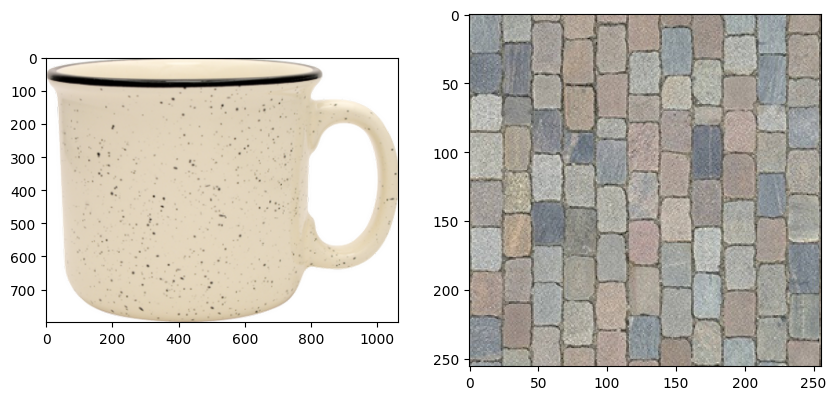

In [2]:
img_1_png = Image.open('example_images/mug.png')
img_1 = Image.new("RGB", img_1_png.size, (255, 255, 255))
img_1.paste(img_1_png, mask=img_1_png.getchannel('A'))

img_2 = Image.open('example_images/brick_texture.jpg')

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

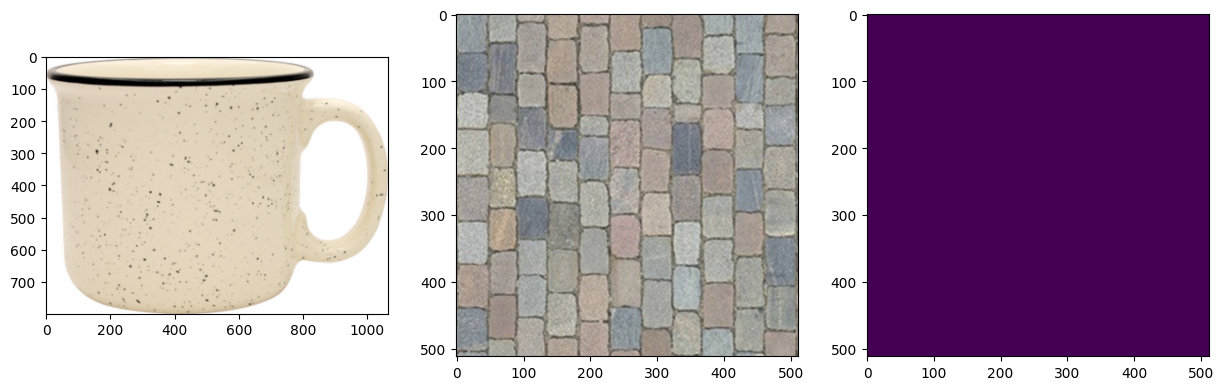

In [3]:
target = TF.to_tensor(img_1)

source = TF.resize(TF.to_tensor(img_2), [512, 512])

corner_coord = torch.tensor([144, 100])

# mask = torch.zeros(source.shape[1:])
# for i in range(mask.shape[0]):
#     for j in range(mask.shape[1]):
#         if ((i - 256) ** 2 + (j - 256) ** 2) ** 0.5 < 200:
#             mask[i, j] = 1
mask = torch.ones(source.shape[1:])

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(torch.movedim(target, 0, -1))
ax[1].imshow(torch.movedim(source, 0, -1))
ax[2].imshow(mask)

In [14]:
target.shape, source.shape

(torch.Size([3, 800, 1065]), torch.Size([3, 512, 512]))

Took  0.09339094161987305


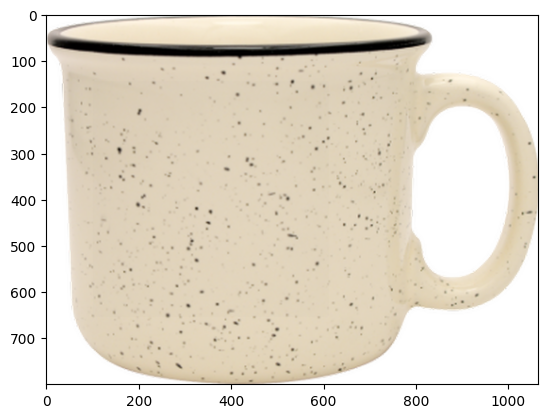

In [ ]:
start = time()
res = pietorch.blend(target, source, torch.zeros(source.shape[1:]), corner_coord, True, channels_dim=0,)
print('Took ', time() - start)

plt.imshow(torch.movedim(res, 0, -1))

tensor(0.) - tensor(0.0024) / tensor(0.) - tensor(0.0365)


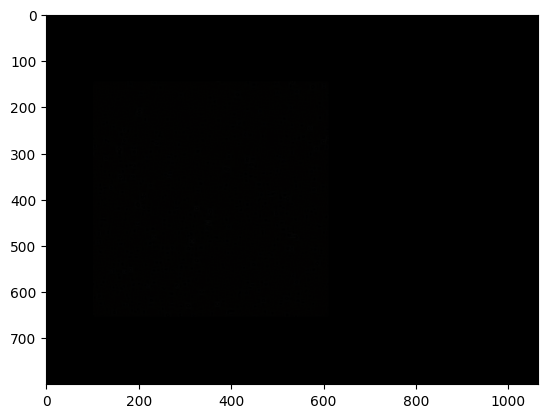

In [5]:
recon_diff = torch.abs(res - target)

print(torch.min(recon_diff), '-', torch.mean(recon_diff), '/', torch.median(recon_diff), '-', torch.max(recon_diff))

plt.imshow(torch.movedim(recon_diff, 0, -1))

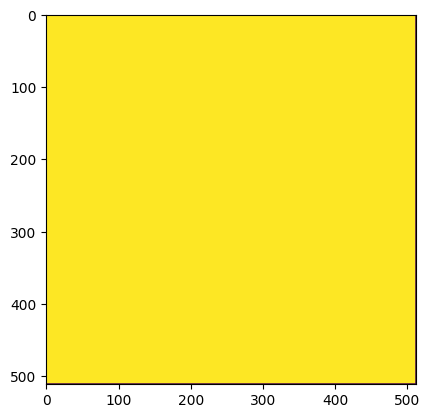

In [15]:
plt.imshow(mask)

In [19]:
target.dtype, source.dtype, mask.dtype

(torch.float32, torch.float32, torch.float32)

In [20]:
mask.max()

tensor(1.)

In [21]:
target.max(), target.min(), source.max(), source.min(), mask.max(), mask.min()

(tensor(1.),
 tensor(0.),
 tensor(0.8993),
 tensor(0.1304),
 tensor(1.),
 tensor(0.))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2353059].


Took  0.07715392112731934


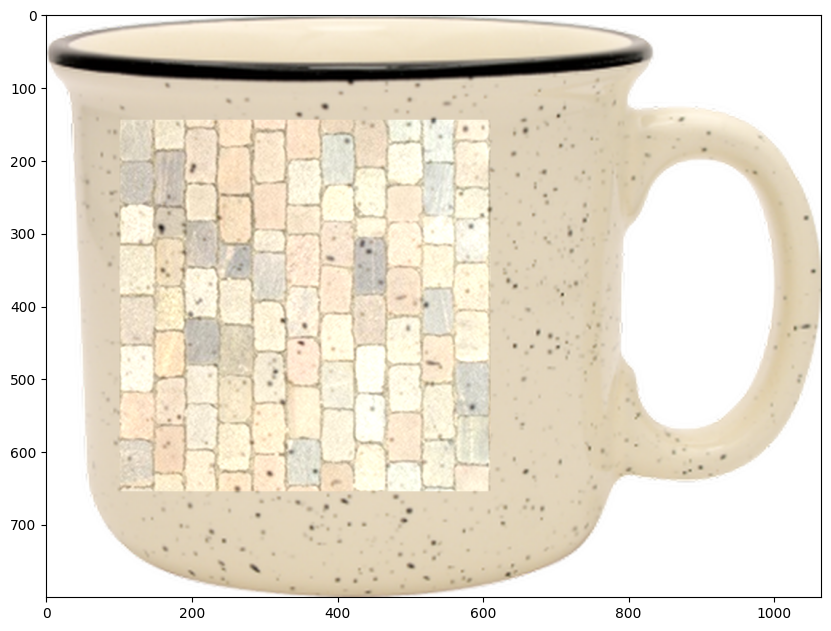

In [6]:
start = time()
res = pietorch.blend(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(torch.movedim(res, 0, -1))

tensor(0.3474)


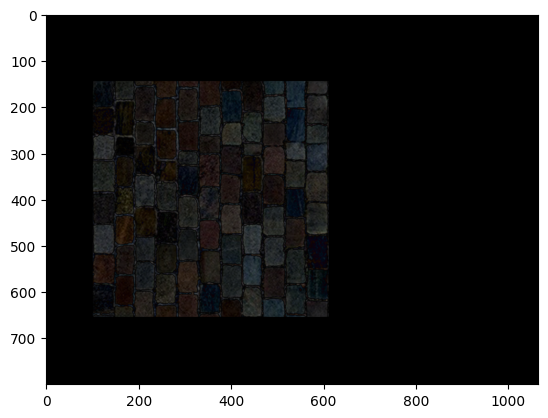

In [7]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))

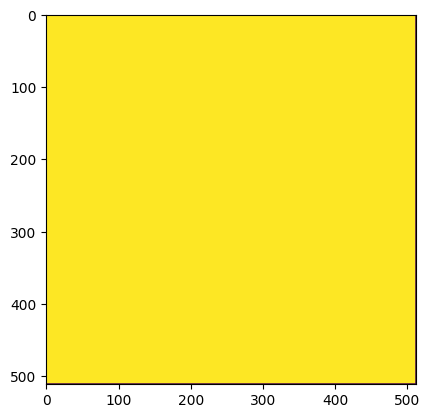

In [16]:
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031044245..1.2145295].


Took  0.1880018711090088


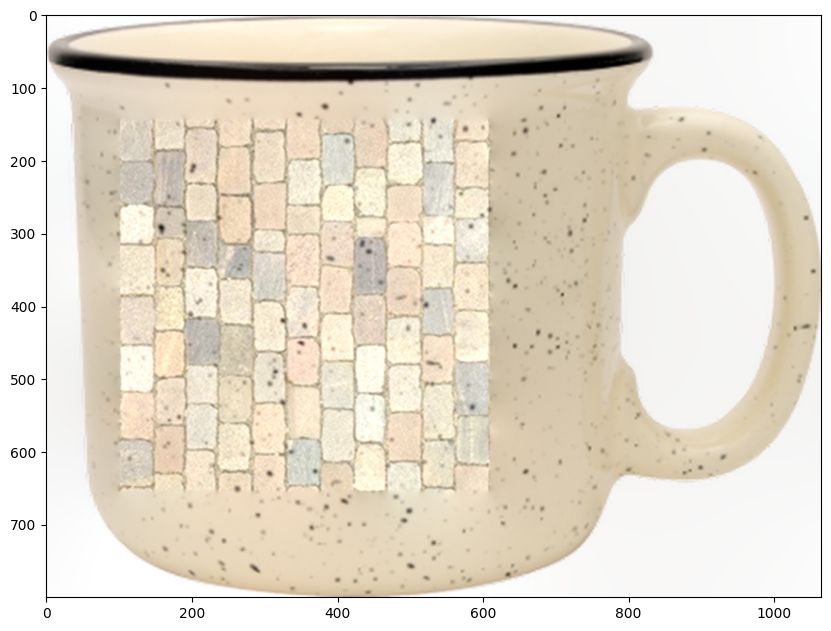

In [8]:
start = time()
res_wide = pietorch.blend_wide(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(torch.movedim(res_wide, 0, -1))

tensor(0.3703)


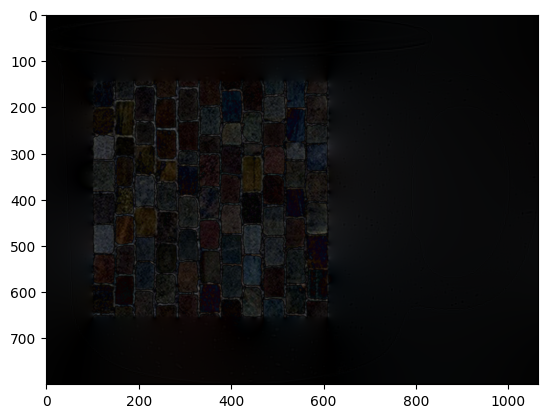

In [9]:
diff_wide = torch.abs(res_wide - target)
print(torch.max(diff_wide))
plt.imshow(torch.movedim(diff_wide, 0, -1))

### Example of using cache

In [ ]:
from pietorch import CachedPoissonBlender

# Add green function to cache ahead of time
cached_blender = CachedPoissonBlender([(source.shape, 0)])

start = time()
res = cached_blender.blend(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)


### 2D OpenCV comparison

In [ ]:
import cv2

cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, [512, 512]))
cv_mask = mask.numpy().astype(np.uint8) * 255
cv_centre_coord = (corner_coord.numpy() + np.array(cv_mask.shape) // 2)

start = time()
cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           tuple(cv_centre_coord[::-1]),
                           cv2.NORMAL_CLONE)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(cv_res)

In [ ]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

In [ ]:
start = time()
cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           tuple(cv_centre_coord[::-1]),
                           cv2.MIXED_CLONE)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(cv_res)

In [ ]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)


### Numpy interface example

In [ ]:
# Apply to OpenCV data, as is already np.ndarray's

np_target = cv_img_1.astype(float)
np_source = cv_img_2.astype(float)
np_mask = mask.numpy()
np_corner_coord = corner_coord.numpy()

start = time()
np_res = pietorch.blend_numpy(np_target, np_source, np_mask, np_corner_coord, True, channels_dim=-1)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(np_res / 255)




In [ ]:
np_diff = np.abs(np_res - cv_res)
print(np.max(np_diff))

plt.imshow(np_diff / 255)

### Try DST implementation (same as OpenCV)

In [ ]:
start = time()
dst_res = pietorch.blend_dst_numpy(np_target, np_source, np_mask, np_corner_coord, True, channels_dim=-1)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(dst_res / 255)

In [ ]:
dst_diff = np.abs(dst_res - cv_res)
print(np.max(dst_diff))

plt.figure(figsize=(10, 8))
plt.imshow(dst_diff / 255)

In [ ]:
_, axes = plt.subplots(ncols=2, figsize=(20, 8))

axes[0].set_title('PIE-torch blend_dst_numpy result')
axes[0].imshow(dst_res / 255)
axes[0].set_axis_off()
axes[1].set_title('OpenCV seamlessClone result')
axes[1].imshow(cv_res / 255)
axes[1].set_axis_off()

In [ ]:

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15, 22))
fig.tight_layout()

ax_row_params = {'fontsize': 28, 'fontname': 'serif', 'labelpad': 15}
ax_title_params = {'fontsize': 28, 'fontname': 'serif', 'pad': 15}

ax[0][0].set_title('Blended Image', **ax_title_params)

ax[0][1].set_title('Difference between\nblended and original', **ax_title_params)

for i, (method_name, blended_res, blended_res_diff) in enumerate(
    [('Green\'s function',              torch.movedim(res, 0, -1), torch.movedim(diff, 0, -1)),
     ('Green\'s function\n over entire image', torch.movedim(res_wide, 0, -1), torch.movedim(diff_wide, 0, -1)),
     ('Original OpenCV',                cv_res, cv_diff),
     ('NumPy implementation\n of OpenCV\'s method', dst_res / 255, np.abs(cv_img_1 - dst_res).astype(int))]):
    
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_ylabel(method_name, **ax_row_params)
    ax[i][0].imshow(blended_res)
    

    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].imshow(blended_res_diff)
    
# fig.savefig('image_blending_comparison.pdf', bbox_inches = 'tight')

## Poisson image editing over time and space

In [ ]:
import imageio

def read_gif(file_path):
    return torch.stack([TF.to_tensor(im) for im in imageio.get_reader(file_path)])

wave = read_gif('example_images/wave.gif')[:, :3]
splat = read_gif('example_images/splat.gif')[:, :3]

In [ ]:
plt.imshow(torch.movedim(wave[0], 0, -1))

In [ ]:
target_gif = wave

source_gif = TF.resize(torch.cat([splat, torch.flip(splat, [0])]), [300, 300])

corner_coord = torch.tensor([4, 100, 100])

mask_gif = torch.ones((source_gif.shape[0], *source_gif.shape[2:]))

In [ ]:
start = time()
res_gif = pietorch.blend(target_gif, source_gif, mask_gif, corner_coord, True, channels_dim=1)
print('Took ', time() - start)

In [ ]:
# Save as gif

def save_gif(tensor, file_path):
    imageio.mimsave(file_path, [TF.to_pil_image(im.clip(0, 1)) for im in tensor], fps=30)

save_gif(res_gif, 'example_images/wave_splat.gif')

In [ ]:
# plt.imshow(torch.movedim(res_gif[10], 0, -1))

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
fig.tight_layout()

frames = [14, 20, 40]

for j, f in enumerate(frames):
    ax[0][j].set_title(f'Frame {f}', **ax_title_params)


for i, (g_name, g) in enumerate([('Target', target_gif),
                       ('Source', source_gif),
                       ('Result', res_gif)]):
    
    ax[i][0].set_ylabel(g_name, **ax_row_params)

    for j, f in enumerate(frames):
        
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        offset = 4 if g_name == 'Source' else 0
        ax[i][j].imshow(torch.movedim(g[f - offset], 0, -1))
        
# fig.savefig('gif_blending_comparison.pdf', bbox_inches = 'tight')

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

gif = res_gif

anim_fig, anim_ax = plt.subplots()
anim_ax.set_axis_off()
img_ax = plt.imshow(torch.movedim(gif[0], 0, -1))

def animate_gif(frame_num):
    img_ax.set_data(torch.movedim(gif[frame_num], 0, -1))
    return img_ax

anim =  FuncAnimation(anim_fig, animate_gif, frames=len(gif), interval=15)
plt.show()

In [ ]:
# anim.save('example_images/blended.gif', fps=30)

### Slice-wise OpenCV comparison

In [ ]:
def read_gif_numpy(file_path: str) -> np.ndarray:
    return np.stack([im for im in imageio.get_reader(file_path)])

cv_wave = read_gif_numpy('example_images/wave.gif')[..., :3]
cv_splat = read_gif_numpy('example_images/splat.gif')[..., :3]

In [ ]:
plt.imshow(cv_wave[0])

In [ ]:
import cv2

cv_target_gif = cv_wave

cv_source_gif = np.stack([cv2.resize(im, (300, 300)) for im in np.concatenate([cv_splat, np.flip(cv_splat, 0)])])

cv_gif_first_frame = 4
cv_gif_centre_coord = (250, 250)

cv_mask_gif = np.ones((300, 300), dtype=np.uint8) * 255

In [ ]:
cv_res_gif = cv_target_gif.copy()
start = time()
for source_frame in range(len(cv_source_gif)):
    target_frame = cv_gif_first_frame + source_frame
    cv_res_gif[target_frame] = cv2.seamlessClone(cv_source_gif[source_frame],
                                                 cv_target_gif[target_frame],
                                                 cv_mask_gif,
                                                 cv_gif_centre_coord,
                                                 cv2.MIXED_CLONE)
print('Took ', time() - start)

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

gif = cv_res_gif

anim_fig, anim_ax = plt.subplots()
anim_ax.set_axis_off()
img_ax = plt.imshow(gif[0])

def animate_gif(frame_num):
    img_ax.set_data(gif[frame_num])
    return img_ax

anim =  FuncAnimation(anim_fig, animate_gif, frames=len(gif), interval=15)
plt.show()

In [ ]:
# anim.save('example_images/cv_blended.gif', fps=30)

## 3D Poisson image editing

In [ ]:
import SimpleITK as sitk

sitk_brain = sitk.ReadImage('example_images/brain.nii.gz')
brain = sitk.GetArrayFromImage(sitk_brain)

brain.shape

In [ ]:
plt.imshow(brain[100], cmap='gray')

In [ ]:
target_3d = torch.from_numpy(brain)

source_3d = torch.zeros((100, 100, 100), dtype=torch.float64)
mask_3d = torch.zeros_like(source_3d, dtype=torch.float64)
radii = centre = np.array(source_3d.shape) // 2

corner_3d = torch.tensor([78, 78, 78])

for i in range(-radii[0], radii[0]):
    for j in range(-radii[1], radii[1]):
        for k in range(-radii[2], radii[2]):
            distance = np.sqrt(i ** 2 + j ** 2 + k ** 2)
            if distance <= 50:
                coord = tuple(np.array([i, j, k]) + centre)
                source_3d[coord] = np.sin(distance * np.pi / 5) / 4
                mask_3d[coord] = 1

In [ ]:
plt.imshow(source_3d[70], cmap='gray')

In [ ]:
start = time()
res_3d = pietorch.blend(target_3d, source_3d, mask_3d, corner_3d, True)
print('Took ', time() - start)

In [ ]:
plt.imshow(res_3d[100], cmap='gray')

In [ ]:
res_3d_sitk = sitk.GetImageFromArray(res_3d.numpy())

res_3d_sitk.CopyInformation(sitk_brain)

res_3d_sitk.GetSpacing()

In [ ]:
sitk.WriteImage(res_3d_sitk, 'example_images/blended_brain.nii.gz')

